# Random Forest for Lake Depth

Random Forest model implemented using RAPIDS AI's cuML and cuDF which run data manipulation, reading, training, etc on GPUs available instead of host CPUs. 

This random forest model takes in a csv which contains instances of tabulated spectral data from a specific raster stack. Each of the rows has 35 data-points 

In [1]:
# Import sytem and python modules

import os
import time
import random
from pprint import pprint
import numpy as np
import cupy as cp

# Import RAPIDS specific modules

import cudf as df
import cuml
from cuml import train_test_split
from cuml.metrics.regression import r2_score as r2d2
from cuml.ensemble import RandomForestRegressor as clRF

# Import sklearn specific modules
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance

# Import data-visualization modules

import matplotlib.pyplot as plt

# 1. Data Preprocessing

In [4]:
# Declare some globals variables and paths
FEATURES_PATH = 'load_dataset/LakeDepth/pts_merged_final.csv'
DEPTH = 'Depth_m'
DATE = 'Date'
FID = 'FID'

TEST_SIZE = 0.2
RANDOM_STATE = 42

In [5]:
# Load everything into GPU-based DF
lakes_depth_df = df.read_csv(FEATURES_PATH)

In [6]:
# Drop unnecessary values from DF
lakes_depth_nd = lakes_depth_df.drop(['FID', 'Date'], axis = 1)
lakes_depth_nd.head(5)

,Depth_m,b1_LC8_075,b2_LC8_075,b3_LC8_075,b4_LC8_075,b5_LC8_075,b6_LC8_075,b7_LC8_075,b8_LC8_075,b9_LC8_075,...,b26_LC8_07,b27_LC8_07,b28_LC8_07,b29_LC8_07,b30_LC8_07,b31_LC8_07,b32_LC8_07,b33_LC8_07,b34_LC8_07,b35_LC8_07
0,0.630000,164,271,199,42,27,16,605,824,3905,...,2625,165,100,136,643,98,59,80,381,593
1,0.672727,165,272,196,44,29,16,607,842,3750,...,2750,176,107,148,659,97,59,82,364,552
2,0.670588,154,260,193,40,32,19,592,798,3850,...,2105,208,123,166,800,123,73,98,475,594
3,0.822222,156,250,195,48,40,26,624,800,3250,...,1846,256,160,205,833,167,104,133,542,650
4,1.725000,117,164,78,38,23,17,713,1500,3079,...,2235,197,140,295,605,145,104,218,447,739


In [7]:
# Inspect data for any anomolies or anything else odd-looking
lakes_depth_nd.describe()

,Depth_m,b1_LC8_075,b2_LC8_075,b3_LC8_075,b4_LC8_075,b5_LC8_075,b6_LC8_075,b7_LC8_075,b8_LC8_075,b9_LC8_075,...,b26_LC8_07,b27_LC8_07,b28_LC8_07,b29_LC8_07,b30_LC8_07,b31_LC8_07,b32_LC8_07,b33_LC8_07,b34_LC8_07,b35_LC8_07
count,23177.000000,23177.000000,23177.000000,23177.000000,23177.000000,23177.000000,23177.000000,23177.000000,23177.000000,23177.000000,...,23177.000000,23177.000000,23177.000000,23177.000000,23177.000000,23177.000000,23177.000000,23177.000000,23177.000000,23177.000000
mean,2.221400,424.288001,553.758079,427.147301,312.433188,175.490055,132.437373,558.585451,922.828753,1900.034603,...,4054.567977,473.428356,410.961686,544.808215,685.495103,332.496527,303.484877,394.607499,499.365880,768.926047
std,1.872953,755.932158,731.549284,630.296958,479.544589,309.819959,244.022402,402.546098,2850.095960,3253.968664,...,6661.986500,2223.950009,539.947680,2837.452024,879.992656,1868.261448,395.559938,2580.861184,801.365571,455.468874
min,0.250000,-151.000000,47.000000,-39.000000,-38.000000,-3.000000,-9.000000,-3213.000000,-32768.000000,-32768.000000,...,-32768.000000,-32768.000000,-8.000000,-32768.000000,-32000.000000,-32768.000000,-22.000000,-32768.000000,-31000.000000,-9667.000000
25%,1.405170,128.000000,235.000000,116.000000,52.000000,29.000000,20.000000,429.000000,607.000000,753.000000,...,1413.000000,126.000000,88.000000,130.000000,391.000000,87.000000,63.000000,94.000000,265.000000,651.000000
50%,1.870750,189.000000,324.000000,224.000000,118.000000,51.000000,37.000000,621.000000,933.000000,1626.000000,...,2126.000000,246.000000,155.000000,271.000000,661.000000,173.000000,105.000000,189.000000,453.000000,734.000000
75%,2.348770,262.000000,441.000000,379.000000,337.000000,164.000000,120.000000,789.000000,1241.000000,3294.000000,...,3500.000000,643.000000,588.000000,843.000000,895.000000,458.000000,460.000000,620.000000,679.000000,828.000000
max,21.037500,5277.000000,5442.000000,4984.000000,5370.000000,2879.000000,2568.000000,4171.000000,32767.000000,32767.000000,...,32767.000000,32767.000000,4128.000000,32767.000000,32767.000000,32767.000000,2771.000000,32767.000000,32767.000000,32767.000000


In [8]:
# Make our acutal_predictions i.e. labels and our covariates dataframes
labels = lakes_depth_nd['Depth_m']
covariates = lakes_depth_nd.drop(['Depth_m'], axis=1)

# Check to ensure everything looks good
labels.head(5)

0    0.630000
1    0.672727
2    0.670588
3    0.822222
4    1.725000
Name: Depth_m, dtype: float64

In [9]:
covariates.head(5)

,b1_LC8_075,b2_LC8_075,b3_LC8_075,b4_LC8_075,b5_LC8_075,b6_LC8_075,b7_LC8_075,b8_LC8_075,b9_LC8_075,b10_LC8_07,...,b26_LC8_07,b27_LC8_07,b28_LC8_07,b29_LC8_07,b30_LC8_07,b31_LC8_07,b32_LC8_07,b33_LC8_07,b34_LC8_07,b35_LC8_07
0,164,271,199,42,27,16,605,824,3905,6074,...,2625,165,100,136,643,98,59,80,381,593
1,165,272,196,44,29,16,607,842,3750,5690,...,2750,176,107,148,659,97,59,82,364,552
2,154,260,193,40,32,19,592,798,3850,4813,...,2105,208,123,166,800,123,73,98,475,594
3,156,250,195,48,40,26,624,800,3250,3900,...,1846,256,160,205,833,167,104,133,542,650
4,117,164,78,38,23,17,713,1500,3079,5087,...,2235,197,140,295,605,145,104,218,447,739


In [10]:
# Make sure we change all our covariate and label data to float32

labels = labels.astype(cp.float32)
covariates = covariates.astype(cp.float32)

Splitting the data to prep for model training phase

In [11]:
cv_train, cv_test, labels_train, labels_test = train_test_split(covariates, labels,
                                                               test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [12]:
# Ensure we have the right size and shapes on our split data
print('Training features shape:', cv_train.shape)
print('Testing features shape:', cv_test.shape)
print('Training labels shape:', labels_train.shape)
print('Testing labels shape:', labels_test.shape)

Training features shape: (18542, 35)
Testing features shape: (4635, 35)
Training labels shape: (18542,)
Testing labels shape: (4635,)


# Training

In [18]:
# Declare some global variables for training phase

# Hyper-paramters
N_ESTIMATORS = 1000
SPLIT_ALGO = 1
SPLIT_CRITERION = 2
BOOTSTRAP = True
BOOTSTRAP_FEATURES = False
ROWS_SAMPLE = 1.0
MAX_DEPTH = 16
MAX_LEAVES = -1
MAX_FEATURES = 'auto'
N_BINS = 8
MIN_ROWS_PER_NODE = 2
MIN_IMPURITY_DECREASE = 0.0
ACCURACY_METRIC = 'r2' # 'median_aw' # 'mean_ae' # 'mse' #
QUANTILEPT = False
SEED = 42
VERBOSE = False

In [19]:
depth_rf_model_0 = clRF(n_estimators = N_ESTIMATORS, 
                        split_algo = SPLIT_ALGO, 
                        split_criterion = SPLIT_CRITERION, 
                        bootstrap = BOOTSTRAP,
                        bootstrap_features = BOOTSTRAP_FEATURES, 
                        rows_sample = ROWS_SAMPLE,
                        max_depth = MAX_DEPTH, 
                        max_leaves = MAX_LEAVES, 
                        max_features = MAX_FEATURES,
                        n_bins = N_BINS,
                        min_rows_per_node = MIN_ROWS_PER_NODE,
                        min_impurity_decrease = MIN_IMPURITY_DECREASE,
                        accuracy_metric = ACCURACY_METRIC,
                        quantile_per_tree = QUANTILEPT,
                        seed = SEED,
                        verbose = VERBOSE)

print(depth_rf_model_0.accuracy_metric)

r2


/home/cssprad1/.conda/envs/rapids-0.16/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Parameter 'seed' is deprecated and will be removed in 0.17. Please use 'random_state' instead. Setting 'random_state' as the curent 'seed' value
  app.launch_new_instance()
/home/cssprad1/.conda/envs/rapids-0.16/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: For reproducible results in Random Forest Classifier or for almost reproducible results in Random Forest Regressor, n_streams==1 is recommended. If n_streams is > 1, results may vary due to stream/thread timing differences, even when random_state is set
  app.launch_new_instance()


In [20]:
%%time
# Train the model (!!)

depth_rf_model_0.fit(cv_train, labels_train)

CPU times: user 13.3 s, sys: 7.89 s, total: 21.2 s
Wall time: 3.58 s


RandomForestRegressor(split_criterion=2, accuracy_metric='r2', handle=<cuml.raft.common.handle.Handle object at 0x7f8292243e30>, verbose=4, output_type='cudf')

# Prediction and analyzing

In [21]:
# Let's get some predictions
score_model_0 = depth_rf_model_0.score(cv_test, labels_test)
#model_0_predictions = depth_rf_model_0.predict(cv_test)
#errors = abs(model_0_predictions - labels_test)
print("Scores --")
print("MAE score:", score_model_0)

Scores --
MAE score: 0.7704753279685974


# Results Visualization

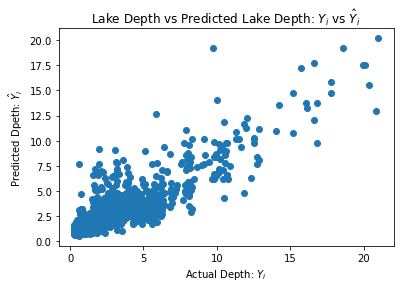

In [22]:
plt.scatter(labels_test.to_array(), model_0_predictions.to_array())
plt.xlabel("Actual Depth: $Y_i$")
plt.ylabel("Predicted Dpeth: $\hat{Y}_i$")
plt.title("Lake Depth vs Predicted Lake Depth: $Y_i$ vs $\hat{Y}_i$")
plt.show()

In [28]:
# Lets look at a random sample of datapoints to see the actual vs predicted depths
for i in range(20):
    random_data_point = random.randint(0, 4635)
    print('Data-point: {:5} Actual: {:20} Predicted: {}'.format(random_data_point, labels_test.to_array()[random_data_point],
                                               model_0_predictions.to_array()[random_data_point]))

Data-point:  3044 Actual:    3.049999952316284 Predicted: 3.5431787967681885
Data-point:  4113 Actual:   1.7921700477600098 Predicted: 1.8322638273239136
Data-point:   598 Actual:     5.60768985748291 Predicted: 7.684330463409424
Data-point:  3420 Actual:   1.8879200220108032 Predicted: 2.0198118686676025
Data-point:   416 Actual:    8.100000381469727 Predicted: 8.11546516418457
Data-point:  1525 Actual:   2.1253600120544434 Predicted: 2.3701353073120117
Data-point:  3821 Actual:   0.5695000290870667 Predicted: 0.7920549511909485
Data-point:  3227 Actual:   2.4059998989105225 Predicted: 2.7249083518981934
Data-point:  1980 Actual:    0.699999988079071 Predicted: 1.048819661140442
Data-point:  3830 Actual:   2.0064001083374023 Predicted: 2.03440523147583
Data-point:  4041 Actual:    1.023859977722168 Predicted: 1.2873930931091309
Data-point:  1890 Actual:    5.417140007019043 Predicted: 3.471553087234497
Data-point:  1310 Actual:    1.753999948501587 Predicted: 1.6761751174926758
Data-p

# Randomized Search - Cross Validation
(We want to find the optimal hyper-parameters)

Randomized search

# Feature Importance

Find the permutation importance using sklearn's implementation (works with cuML models)

In [29]:
%%time
perm_imp = permutation_importance(depth_rf_model_0, cv_test, labels_test)
spectral_bands_list = list(covariates.columns)
importances = perm_imp.importances_mean
feature_importances = [(feature, -1*(round(importance, 5))) for
                      feature, importance in zip(spectral_bands_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variables: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variables: b31_LC8_07           Importance: -0.003
Variables: b11_LC8_07           Importance: -0.00536
Variables: b32_LC8_07           Importance: -0.00575
Variables: b16_LC8_07           Importance: -0.0061
Variables: b15_LC8_07           Importance: -0.00767
Variables: b27_LC8_07           Importance: -0.00812
Variables: b29_LC8_07           Importance: -0.0086
Variables: b4_LC8_075           Importance: -0.00938
Variables: b34_LC8_07           Importance: -0.00958
Variables: b9_LC8_075           Importance: -0.01031
Variables: b30_LC8_07           Importance: -0.01035
Variables: b21_LC8_07           Importance: -0.0152
Variables: b5_LC8_075           Importance: -0.01715
Variables: b35_LC8_07           Importance: -0.01868
Variables: b14_LC8_07           Importance: -0.01935
Variables: b22_LC8_07           Importance: -0.02004
Variables: b28_LC8_07           Importance: -0.02069
Variables: b33_LC8_07           Importance: -0.02106
Variables: b10_LC8_07           Importance: -0.0253

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]